In [77]:
import os
import glob
import pathlib
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Extracting files


In [78]:
def extract_files(folder_path):
    csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
    dataframes = []

    for file in csv_files:
        df = pd.read_csv(file)
        dataframes.append(df)
    return dataframes


extracted = extract_files("Topic_modelling")

In [79]:
alldata = pd.DataFrame()
for listitems in extracted:
    alldata = pd.concat([alldata, listitems])

## Feature extraction

In [80]:
alldata.head()

,headlines,description,content,url,category
0,Nirmala Sitharaman to equal Morarji Desai’s re...,With the presentation of the interim budget on...,"Sitharaman, the first full-time woman finance ...",https://indianexpress.com/article/business/bud...,business
1,"‘Will densify network, want to be at least no....","'In terms of market share, we aim to double it...",The merger of Tata group’s budget airlines Air...,https://indianexpress.com/article/business/avi...,business
2,Air India group to induct an aircraft every si...,Air India currently has 117 operational aircra...,The Air India group plans to induct one aircra...,https://indianexpress.com/article/business/avi...,business
3,Red Sea woes: Exporters seek increased credit ...,Rising attacks forced shippers to consider the...,Indian exporters have asked the central govern...,https://indianexpress.com/article/business/red...,business
4,Air India group to induct a plane every 6 days...,"Apart from fleet expansion, 2024 will also see...",The Air India group plans to induct one aircra...,https://indianexpress.com/article/business/avi...,business


In [81]:
targets = alldata["category"]
feature = alldata["headlines"]

In [82]:
print(feature)

0       Nirmala Sitharaman to equal Morarji Desai’s re...
1       ‘Will densify network, want to be at least no....
2       Air India group to induct an aircraft every si...
3       Red Sea woes: Exporters seek increased credit ...
4       Air India group to induct a plane every 6 days...
                              ...                        
1995    Vivaldi’s privacy and customisability-focused ...
1996    From Meta Quest 3 to Ray Ban Smart Glasses, he...
1997    Samsung Galaxy S24 rumoured to launch on Janua...
1998    ‘We continuously iterate… building prototypes,...
1999    ChatGPT users can now browse internet, OpenAI ...
Name: headlines, Length: 10000, dtype: object


### Using TfIDvectorizer

In [83]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import pickle

cv = KFold(n_splits=10, shuffle=True, random_state=42)

**Preparing TFID vectors for OneVsRest Model**

In [84]:
x_train_tf, x_test_tf, y_train_tf, y_test_tf = train_test_split(feature, targets, test_size = 0.3, random_state=42)

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_vectorizer.fit(x_train_tf)
x_train_tfid = tfidf_vectorizer.transform(x_train_tf)
x_test_tfid = tfidf_vectorizer.transform(x_test_tf)

In [98]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_tf = le.fit_transform(y_train_tf)
y_test_tf = le.transform(y_test_tf.ravel())

ValueError: invalid literal for int() with base 10: 'sports'

In [86]:
pickle.dump(tfidf_vectorizer, open('transformer_model.pkl', 'wb'))

In [87]:
#tree = DecisionTreeClassifier()
parameters = {
    'max_depth':[2, 4, 6, 8],
    'min_samples_split':[2, 5, 10],
    'min_samples_leaf':[2, 5, 10]
    }
clftree = GridSearchCV(tree, parameters, cv=cv)
clftree.fit(x_train_tfid, y_train_tf)
besttree = clftree.best_estimator_
#DecisionTreeClassifier(max_depth=8, min_samples_leaf=5, min_samples_split=10)

In [88]:
tree = DecisionTreeClassifier()

In [89]:
parameters = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.01, 0.001]
    }

ada_clf = AdaBoostClassifier(estimator=tree, algorithm="SAMME", random_state=42)


In [90]:
grid_search = GridSearchCV(ada_clf, param_grid=parameters, cv=cv)

In [91]:
grid_search.fit(x_train_tfid, y_train_tf)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          estimator=DecisionTreeClassifier(),
                                          random_state=42),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'n_estimators': [50, 100, 200]})

In [92]:
ada_clf_tfid = grid_search.best_estimator_

In [93]:
ovr = OneVsRestClassifier(ada_clf_tfid)

In [94]:
ovr.fit(x_train_tfid, y_train_tf)

OneVsRestClassifier(estimator=AdaBoostClassifier(algorithm='SAMME',
                                                 estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.1,
                                                 random_state=42))

In [95]:
ypreds_ovr = ovr.predict(x_test_tfid)

scorestree = cross_val_score(ovr, x_train_tfid, y_train_tf)
print("Cross-validation scores Tree: ", np.round(np.mean(scorestree),3))

Cross-validation scores Tree:  0.818


In [96]:
pickle.dump(ovr, open("ovr_model.pkl", "wb"))

In [97]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
cm_ovr = classification_report(y_test_tf, ypreds_ovr)
print(cm_ovr)

ValueError: Mix of label input types (string and number)

Text(0.5, 1.0, 'Confusion Matrix Model with Tfid representation Adaboost/OneVsRest model')

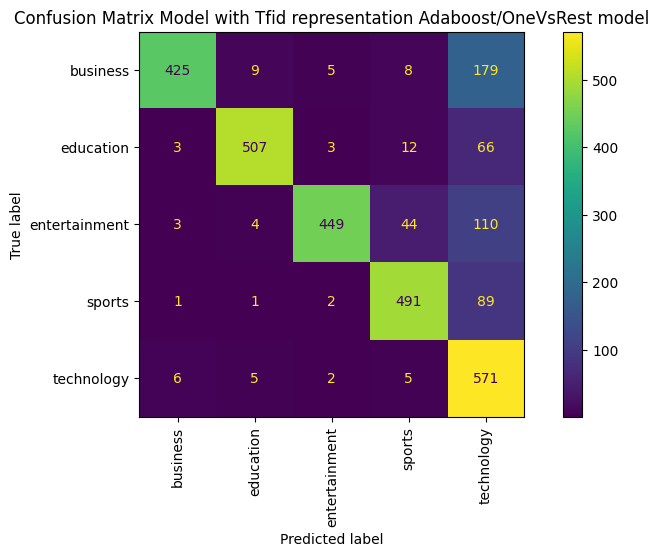

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
disp2 = ConfusionMatrixDisplay.from_predictions(y_test_tf, ypreds_ovr, ax=ax,
                                               xticks_rotation="vertical")
#ax.xaxis.set_ticklabels(classnames.values())
#ax.yaxis.set_ticklabels(classnames.values())
plt.title("Confusion Matrix Model with Tfid representation Adaboost/OneVsRest model")